# Prepare the Environment
Virtual environment implementations are different depends on the Jupyter Notebook execution platforms. Therefore, some changes may be required to create the virtual environment. However, all key commands are included in the "prep_env.sh" shell script.

In [85]:
!sh '/content/prep_env.sh'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
created virtual environment CPython3.10.11.final.0-64 in 347ms
, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==23.1.2, setuptools==67.7.2, wheel==0.40.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
: not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

✘ No compatible package found for 'en_core_web_md ' (spaCy v3.5.2)



# Build a Simple Data Pipeline
- Read a CSV file containing text data and ensure all rows are valid

In [86]:
# load dependencies
import yaml
import pandas as pd


# load config
with open('/content/data/configs.yaml', errors='ignore') as f:
    configs = yaml.safe_load(f)


# load data, set data type and drop invalid rows
df_data = pd.read_csv(configs['data_file']).astype({'description':'string'}).dropna()
# automatically assign id by row id
df_data['id'] = range(0, 0+len(df_data))
# change description to lower case
df_data['description'] = df_data['description']


In [87]:
print('df_data summary')
df_data.info()
df_data.head()

df_data summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4535 entries, 0 to 4534
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  4535 non-null   string
 1   id           4535 non-null   int64 
dtypes: int64(1), string(1)
memory usage: 71.0 KB


,description,id
0,We invite you to join us at Driven Brands! Hea...,0
1,Sabot Consulting (Sabot) is a management consu...,1
2,Job Details Apply Save Print this job Email a ...,2
3,Position: Data Engineer Location: MN As a Data...,3
4,Full Job Description The Network Administrator...,4


# Basic NLP Tasks - 1st Stage
This stage ensure the text field does not have:
- any irrelevant information (e.g., header and footer information)
- locations
- stop words, punctuation, and non-alphabetic characters

Along with these tasks:
- tokenize the text data into individual words or phrases

In [88]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
# prepare required data
# load the stopwords corpus
nltk.download('stopwords')
# download the WordNet corpus
nltk.download('wordnet')

en_stop_words = set(stopwords.words(configs['stopwords_code']))
import spacy
# Load a pre-trained model with NER capabilities
nlp = spacy.load(configs['spacy_model'])
# define regular expressions for header and footer patterns
header_pattern = re.compile(r'^header*')
footer_pattern = re.compile(r'^footer*')



def remove_header_footer(text: string):
    # Tokenize the text into sentences
    lines = nltk.sent_tokenize(text)
    # Remove any lines that match the header or footer pattern
    lines = [line for line in lines if not header_pattern.match(line) and 
             not footer_pattern.match(line)]
    # Join the remaining lines back into a single string
    cleaned_text = '\n'.join(lines)
    return cleaned_text


def remove_punctuation(text: string):
    import string
    # Define the punctuation characters to remove
    punctuations = string.punctuation
    # Replace the punctuation characters with spaces    
    cleaned_text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return cleaned_text


def remove_stopwords(text: string, stop_words: set):
    tokens = nltk.word_tokenize(text)
    # filter out general stop words
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    # Join the filtered tokens back into a string
    filtered_text = ' '.join(filtered_tokens)    
    return(filtered_text)


def remove_by_ner(text: string):
    """remove words by named entity recognition"""
    doc = nlp(text)
    # create a new list of tokens without any location entities
    new_tokens = [token.text for token in doc if token.ent_type_ not in ['DATE', 'MONEY', 'LOC']]
    # join the new list of tokens into a clean text string
    clean_text = ' '.join(new_tokens)

    return clean_text



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [89]:
# apply 1st stage of cleanup
df_data['cleaned_text'] = df_data['description'].\
                        apply(remove_punctuation).\
                        apply(remove_header_footer).\
                        apply(remove_stopwords, stop_words=en_stop_words).\
                        apply(remove_by_ner)


# Exploratory Data Analysis

In [110]:
# generate the words summary
import os
from collections import Counter

def calculate_words_count(df: pd.DataFrame, text_field: string, output_name: string):
    # combine all rows of the text column into a single string
    all_cleaned_text = ' '.join(df[text_field]).lower()
    # split the text string into a list of words
    words = all_cleaned_text.split()

    # count the frequency of each word using the Counter class
    word_counts = Counter(words)
    # create a new DataFrame for the word counts summary
    word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count']).sort_values('count', ascending=False)
    # export the summary to assist with 2nd stage cleanup
    word_counts_df.to_csv(os.path.join(configs['output_path'], output_name))
    print(word_counts_df)
    return all_cleaned_text


all_cleaned_text = calculate_words_count(df=df_data, text_field='cleaned_text', output_name='word_counts_summary.csv')


             count
data         23923
•            13251
â¢          12201
team          8948
business      8586
...            ...
hmai             1
populations      1
servedrefer      1
aidet            1
bigml            1

[29172 rows x 1 columns]


## Obtain a reasonable understanding visually on current jobs in the database

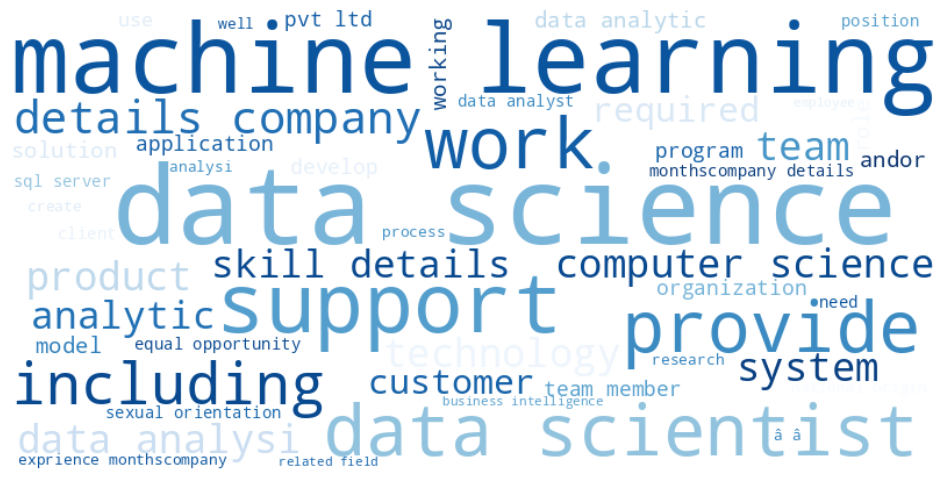

<Figure size 640x480 with 0 Axes>

In [108]:
def plot_words_cloud(all_text_str: string, cloud_img_name: string):
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud

    # create a WordCloud object with some basic parameters
    word_cloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues', max_words=50).generate(all_text_str)

    # plot the WordCloud image
    plt.figure(figsize=(12, 10))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    plt.savefig(os.path.join(configs['output_path'], cloud_img_name))

plot_words_cloud(all_text_str=all_cleaned_text, cloud_img_name='words_cloud.png')


# Basic NLP Tasks - 2nd Stage
After the EDA, further cleaning is implemented to ensure text data is in good condition for later use.

This stage ensure the text field does not have:
- any irrelevant information
- custom stop words found from the earlier EDA

Along with these tasks:
- normalize the text data to their base form using lemmatization and then stemming.
- Transform the text data into a format suitable for machine learning (e.g., word embeddings)

In [92]:
def stemming(text: string):
    from nltk.stem import PorterStemmer
    ps = PorterStemmer()
    return ps.stem(text)


def word_lemmatizer(text: string):
    from nltk.stem import WordNetLemmatizer
    # create a WordNet lemmatizer object
    lemmatizer = WordNetLemmatizer()
    # split the sentence into a list of words
    words = nltk.word_tokenize(text)
    # lemmatize each word in the list
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    # join the lemmatized words back into a sentence
    processed_text = ' '.join(lemmatized_words)

    return processed_text


def word_embeddings(text: string):
    # Tokenize the text
    doc = nlp(text)
    result = {}
    tokens_text, tokens_vector = [], []

    # Access the vector representation of each token in the document
    for token in doc:
      tokens_text.append(token.text)
      tokens_vector.append(token.vector)

    result['tokens_text'] = tokens_text
    result['tokens_vector'] = tokens_vector
    return result


# apply 2nd stage of cleanup
# filter out (some example) irrelevant keywords from EDA (e.g., general competence)
df_data['cleaned_text'] = df_data['cleaned_text'].\
                        apply(remove_stopwords, stop_words=configs['custom_stop_words']).\
                        apply(word_lemmatizer).apply(stemming)


# Implement the Machine Learning Model
The machine learning model should be implemented using any NLP framework of your choice (e.g.,
spaCy, NLTK, scikit-learn, or any other framework you like). The model should take in the
transformed text data from the data pipeline and generate a list of skills that are mentioned in the
text.

The model should be designed to handle the following tasks:

1. Identifying relevant phrases or keywords that indicate a skill (e.g., "programming", "Java",
"data analysis").
2. Classifying the identified phrases or keywords into different skill categories (e.g., technical
skills, soft skills).
3. Filtering out irrelevant phrases or keywords (e.g., common words that do not indicate a
skill).
The model should be able to handle a large volume of text data and should be scalable.

In [93]:
"""Identifying relevant phrases or keywords that indicate a skill"""
nltk.download('averaged_perceptron_tagger')


def identify_skills(text: string):
    # Tokenize the text
    doc = nlp(text)
    tokens = nltk.word_tokenize(text)
    # Tag parts of speech for each token
    tagged = nltk.pos_tag(tokens)
    skills = []

    # Extract skills using part-of-speech tagging    
    for i in range(len(tagged)):        
        if tagged[i][1] == 'NN' or tagged[i][1] == 'NNS':
          if i < len(tagged) - 1 and (tagged[i+1][1] == 'NN' or tagged[i+1][1] == 'NNS'):
              skills.append(tagged[i][0] + ' ' + tagged[i+1][0])
          else:
              skills.append(tagged[i][0])
        elif tagged[i][1] in ['NNP', 'VBG']:          
            skills.append(tagged[i][0])

    # Remove duplicates
    skills = list(set(skills))

    return skills


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [94]:
df_data['skills'] = df_data['cleaned_text'].apply(identify_skills)


In [95]:
df_data['skills'].view()

0       [vision description, performance innovation, a...
1       [design development, sustainability, rfi reque...
2            [email friend, print email, friend, details]
3       [eg h1b, familiarity, privacy notice, bachelor...
4       [diagnoses, evaluating, problem escalation, en...
                              ...                        
4530    [check acb, gate powai, â¢ check, â¢ people,...
4531    [ï¶, resolve, interpret, efficiency company, ...
4532    [industries, fathers, assembly core, bodys ins...
4533    [micro wind, quality engineer, education pune,...
4534    [html css, security role, exprience, software,...
Name: skills, Length: 4535, dtype: object

In [96]:
def classify_skills(skills):
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.naive_bayes import MultinomialNB

    # example dataset with identified phrases and their corresponding skill categories
    skills_data = {'phrase': ['Java', 'Python', 'Statistics', 'Data Science',
                          'Communication', 'Problem solving', 'Teamwork'],
        'category': ['Technical Skills', 'Technical Skills', 'Technical Skills', 'Technical Skills', 
                     'Soft Skills', 'Soft Skills', 'Soft Skills']}

    df_skills = pd.DataFrame(skills_data)
    
    # fit and training
    # Convert phrases into vectors using the CountVectorizer
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df_skills['phrase'])

    # Create a Multinomial Naive Bayes model and fit it to the data
    clf = MultinomialNB()
    clf.fit(X, df_skills['category'])

    
    # inference and predict
    if len(skills) > 0:
        # Convert text into a vector using the same CountVectorizer
        text_vec = vectorizer.transform(skills)

        # Classify the text using the trained model
        predicted_category = clf.predict(text_vec)

        return predicted_category


In [97]:
# Classifying the identified phrases or keywords into different skill categories (e.g., technical skills, soft skills).
df_data['skill_categories'] = df_data['skills'].apply(classify_skills)


In [98]:
# Filtering out irrelevant phrases or keywords (e.g., common words that do not indicate a skill). 
# this is performed within remove_stopword() during data pre-processing stage 


# Solution Scalability

Because it is instructed to conduct this project in Jupyter Notebook, rather than script files. Therefore, it's easier to discuss Scalability by simple examples rather than implementation.

- Batch processing: When processing large volumes of text data, it is often necessary to process the data in batches to avoid running out of memory or exceeding processing time limits. Batch processing involves breaking the data into smaller chunks and processing each chunk separately.

- Distributed processing: Use distributed processing frameworks, such as Apache Spark or Hadoop, to process the data in parallel across multiple machines.


## Layout of Batch processing

In [99]:
# set batch size by memory setup
batch_size = 1000


# Process data in batches
def process_batch_data(df_data: pd.DataFrame):
    for i in range(0, len(df_data), batch_size):
        batch = df_data[i:i+batch_size]

        prepared_data = prepare_data(batch)
        # prediction by batches
        processed_batch = predict_skills_categories(prepared_data)

        # write to data destination
        write_to_db(processed_batch)


def main(config_file_path: string):
    configs = load_config(config_file_path)
    df_data = load_data(configs)
    process_batch_data(df_data)    



## Other Options
- Use efficient data structures, e.g. using sparse matrices or compressed representations of text data to reduce memory usage and improve performance.

- Analyse the nature of data and use corresponding pre-processing techniques

- Test and use the optimal pre-trained models (e.g. BERT or GPT), followed by fine-tuning.

- Use algorithms that can be run parallelized, such as matrix factorization

- Store checkpoints during implementation to enable quick resumption if the process is stopped due to memory, hardware, software issues.

# Result Presentation

## The full data frame result

In [100]:
df_data

,description,id,cleaned_text,skills,skill_categories
0,We invite you to join us at Driven Brands! Hea...,0,invite join u driven brands headquartered char...,"[vision description, performance innovation, a...","[Technical Skills, Technical Skills, Technical..."
1,Sabot Consulting (Sabot) is a management consu...,1,sabot consulting sabot management consulting c...,"[design development, sustainability, rfi reque...","[Technical Skills, Technical Skills, Technical..."
2,Job Details Apply Save Print this job Email a ...,2,details apply save print email friend,"[email friend, print email, friend, details]","[Technical Skills, Technical Skills, Technical..."
3,Position: Data Engineer Location: MN As a Data...,3,position data engineer location mn data engine...,"[eg h1b, familiarity, privacy notice, bachelor...","[Technical Skills, Technical Skills, Technical..."
4,Full Job Description The Network Administrator...,4,full description network administrator provide...,"[diagnoses, evaluating, problem escalation, en...","[Technical Skills, Technical Skills, Soft Skil..."
...,...,...,...,...,...
4530,Computer Skills: â¢ Proficient in MS office (...,4530,computer â¢ proficient ms office word basic e...,"[check acb, gate powai, â¢ check, â¢ people,...","[Technical Skills, Technical Skills, Technical..."
4531,â Willingness to accept the challenges. â ...,4531,â willingness accept challenge â positive ...,"[ï¶, resolve, interpret, efficiency company, ...","[Technical Skills, Technical Skills, Technical..."
4532,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",4532,personal â¢ quick learner â¢ eagerness learn...,"[industries, fathers, assembly core, bodys ins...","[Technical Skills, Technical Skills, Technical..."
4533,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,4533,computer software mspower point ms office c pr...,"[micro wind, quality engineer, education pune,...","[Technical Skills, Technical Skills, Technical..."


## The Extracted Skills Summary

                  count
data              26306
business          11657
team              10464
work               8386
company            7585
...                 ...
wwwsavangroupcom      1
homelessness          1
inefficient           1
crippling             1
dalene                1

[18963 rows x 1 columns]


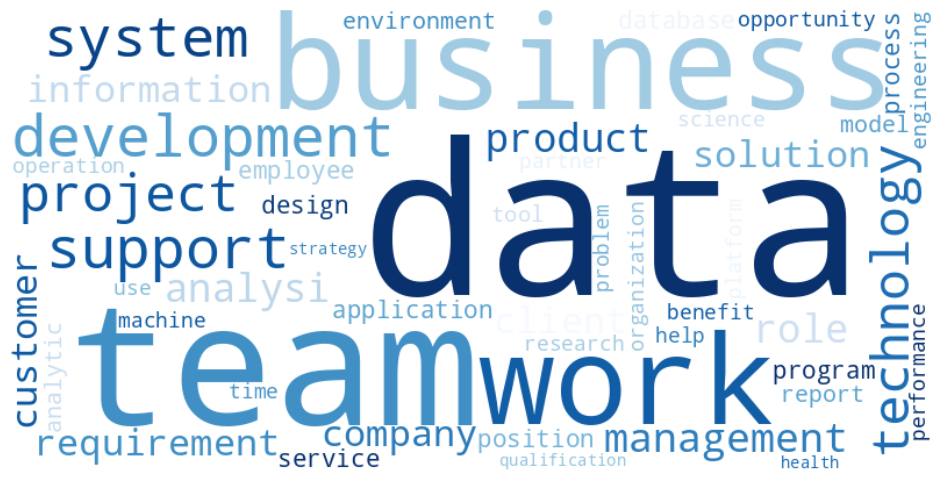

<Figure size 640x480 with 0 Axes>

In [122]:
df_data['all_skills'] = df_data['skills'].str.join(' ')
all_skills = calculate_words_count(df=df_data, text_field='all_skills', output_name='skills_counts_summary.csv')
plot_words_cloud(all_text_str=all_skills, cloud_img_name='skills_cloud.png')


## The Predicted Skills Categories Summary

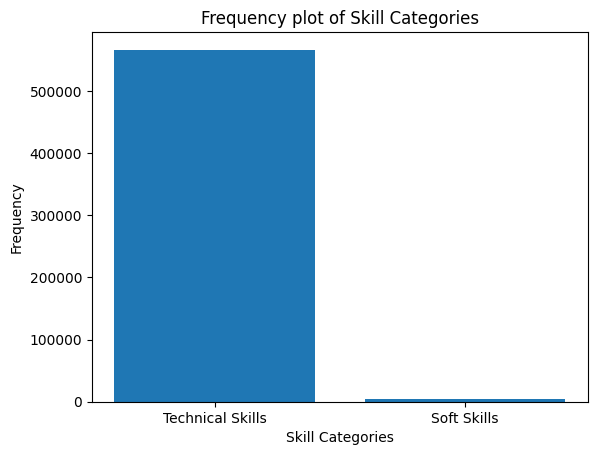

In [129]:
# compute the frequency of each element in the list column
freq_table = pd.Series([item for sublist in df_data['skill_categories'] for item in sublist]).value_counts()

# plot the frequency plot using Matplotlib
plt.bar(freq_table.index, freq_table.values)
plt.title('Frequency plot of Skill Categories')
plt.xlabel('Skill Categories')
plt.ylabel('Frequency')
plt.show()


# Unit Tests
This section includes some basic unit tests to test available functions

In [137]:
import unittest


class TestFirstStageCleaning(unittest.TestCase):

    def setUp(self):
        self.str_punct = 'Hello, World! This is an example text with punctuation.'
        self.str_head_foot = 'HEADER: This is the.\n\nI am reading.\n\nFOOTER: This is the footer information.'.lower()
        self.str_stopwords = 'you will make an impact in the following ways with us'        
        self.str_custom_stopwords = 'experience in Java focus on communication knowledge in Python'

    def test_givenAStringHasPunctuations_whenRemovePunctuationIsCalled_thenGetAStringWithNoPunctuations(self):
        expected_result = 'Hello World This is an example text with punctuation'
        result = remove_punctuation(self.str_punct)
        self.assertEqual(expected_result, result)

    def test_givenAStringHasHeaderFooter_whenRemoveHeaderFooterIsCalled_thenGetAStringWithNoHeaderFooter(self):
        expected_result = 'I am reading.'.lower()
        result = remove_header_footer(self.str_head_foot)
        self.assertEqual(expected_result, result)

    def test_GivenAStringHasEnglishStopWords_whenRemoveStopwordsIsCalled_thenGetAStringWithNoStopwords(self):
        expected_result = 'make impact following ways us'
        result = remove_stopwords(self.str_stopwords, stop_words=en_stop_words)
        self.assertEqual(expected_result, result)

    def test_GivenAStringHasCustomStopWords_whenRemoveStopwordsIsCalled_thenGetAStringWithNoCustomStopwords(self):
        custom_stop_words = ['experience', 'knowledge', 'skills', 'ability', 'proficiency', 
                        'expert', 'good', 'advanced', 'focus', 'reporting']
        expected_result = 'in Java on communication in Python'
        result = remove_stopwords(self.str_custom_stopwords, stop_words=custom_stop_words)
        self.assertEqual(expected_result, result)


class TestSecondStageCleaning(unittest.TestCase):

    def setUp(self):
      self.str_skills = 'with programming such as Python and Java, as well as data analysis such as Pandas and Numpy, are required.'
      self.str_lem = 'The cats are playing with the balls.'

    def test_GivenAString_whenExtractSkills_thenReturnAListOfSkills(self):
        expected_result = ['Java', 'Numpy', 'Python', 'Pandas', 'analysis', 'data analysis', 'programming']
        result = identify_skills(self.str_skills)
        self.assertEqual(expected_result, result)

    def test_GivenAString_whenLemmatingWords_thenReturnAListOfLemmatizedSentence(self):
        expected_result = 'The cat are playing with the ball .'
        result = word_lemmatizer(self.str_lem)
        self.assertEqual(expected_result, result)



In [138]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_GivenAStringHasCustomStopWords_whenRemoveStopwordsIsCalled_thenGetAStringWithNoCustomStopwords (__main__.TestFirstStageCleaning) ... ok
test_GivenAStringHasEnglishStopWords_whenRemoveStopwordsIsCalled_thenGetAStringWithNoStopwords (__main__.TestFirstStageCleaning) ... ok
test_givenAStringHasHeaderFooter_whenRemoveHeaderFooterIsCalled_thenGetAStringWithNoHeaderFooter (__main__.TestFirstStageCleaning) ... ok
test_givenAStringHasPunctuations_whenRemovePunctuationIsCalled_thenGetAStringWithNoPunctuations (__main__.TestFirstStageCleaning) ... ok
test_GivenAString_whenExtractSkills_thenReturnAListOfSkills (__main__.TestSecondStageCleaning) ... ok
test_GivenAString_whenLemmatingWords_thenReturnAListOfLemmatizedSentence (__main__.TestSecondStageCleaning) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.054s

OK


In [104]:
# update dependencies versions
!/content/smart_recruit/bin/python3 -m pip freeze > /content/requirements.txt